# The Big Picture - Describing Networks

## Global structure

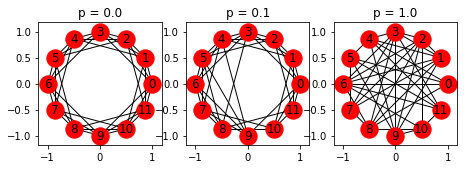

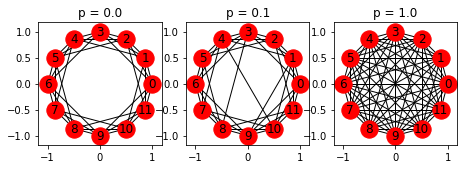

In [75]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from pathlib import Path
data_dir = Path('.') / 'data'

G_social = nx.read_edgelist(data_dir / 'mcauley2020-facebook-combined.txt')

plt.figure(figsize=(7.5, 2.25))
for i, p in enumerate([0.0, 0.1, 1.0]):
    # Generate the graph
    G = nx.watts_strogatz_graph(12, 6, p)
    # Create layout and draw
    plt.subplot(1, 3, i + 1)
    pos = nx.circular_layout(G)
    nx.draw_networkx(G, pos=pos)
    plt.title("p = {:0.1f}".format(p))  

plt.figure(figsize=(7.5, 2.25))
for i, p in enumerate([0.0, 0.1, 1.0]):
    # Generate the graph
    G = nx.newman_watts_strogatz_graph(12, 6, p)
    # Create layout and draw
    plt.subplot(1, 3, i + 1)
    pos = nx.circular_layout(G)
    nx.draw_networkx(G, pos=pos)
    plt.title("p = {:0.1f}".format(p))

## Preferential attachment (Barabasi-Albert model) and heavy-tailed networks

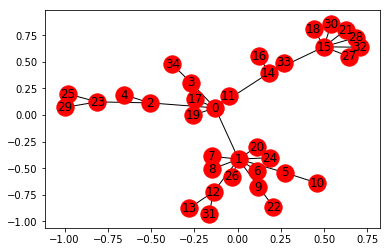

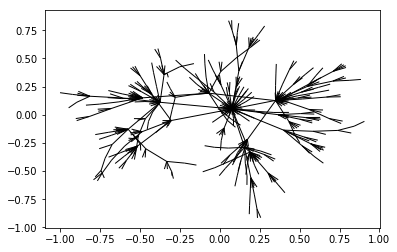

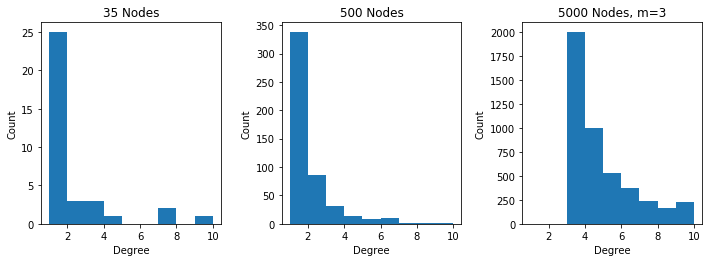

In [76]:
G_preferential_35 = nx.barabasi_albert_graph(35, 1)
pos = nx.spring_layout(G_preferential_35, k=0.1)
nx.draw_networkx(G_preferential_35, pos)

# Larger example
plt.figure()
G_preferential_500 = nx.barabasi_albert_graph(500, 1)
pos = nx.spring_layout(G_preferential_500)
nx.draw_networkx(G_preferential_500, pos, node_size=0, with_labels=False)

G_preferential_5000_2 = nx.barabasi_albert_graph(5000, 3)


# Show heavy tail
def plot_degree_hist(G, title):
    """Plot histogram of node degrees."""
    plt.hist(dict(nx.degree(G)).values(), bins=range(1, 11))
    # Label axes
    plt.xlabel('Degree')
    plt.ylabel('Count')
    plt.title(title)

plt.figure(figsize=(10, 3.75))
ax = plt.subplot(1,3,1)
plot_degree_hist(G_preferential_35, '35 Nodes')
for spine in ax.spines.values():
    spine.set_visible(True)
ax = plt.subplot(1,3,2)
for spine in ax.spines.values():
    spine.set_visible(True)
plot_degree_hist(G_preferential_500, '500 Nodes')
ax = plt.subplot(1,3,3)
plot_degree_hist(G_preferential_5000_2, '5000 Nodes, m=3')
plt.tight_layout()

## Configuration networks

True


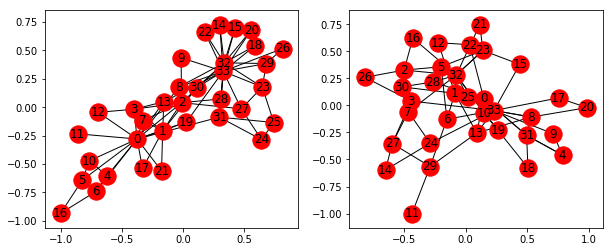

In [77]:
G_karate = nx.karate_club_graph()
degree_sequence = dict(nx.degree(G_karate)).values()
# Generate a random network with the same node degrees
G2 = nx.degree_seq.configuration_model(degree_sequence)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
nx.draw_networkx(G_karate)
plt.subplot(1,2,2)
nx.draw_networkx(G2)

print(dict(nx.degree(G_karate))==dict(nx.degree(G2)))

## Agent-based modeling: learning-based estimation

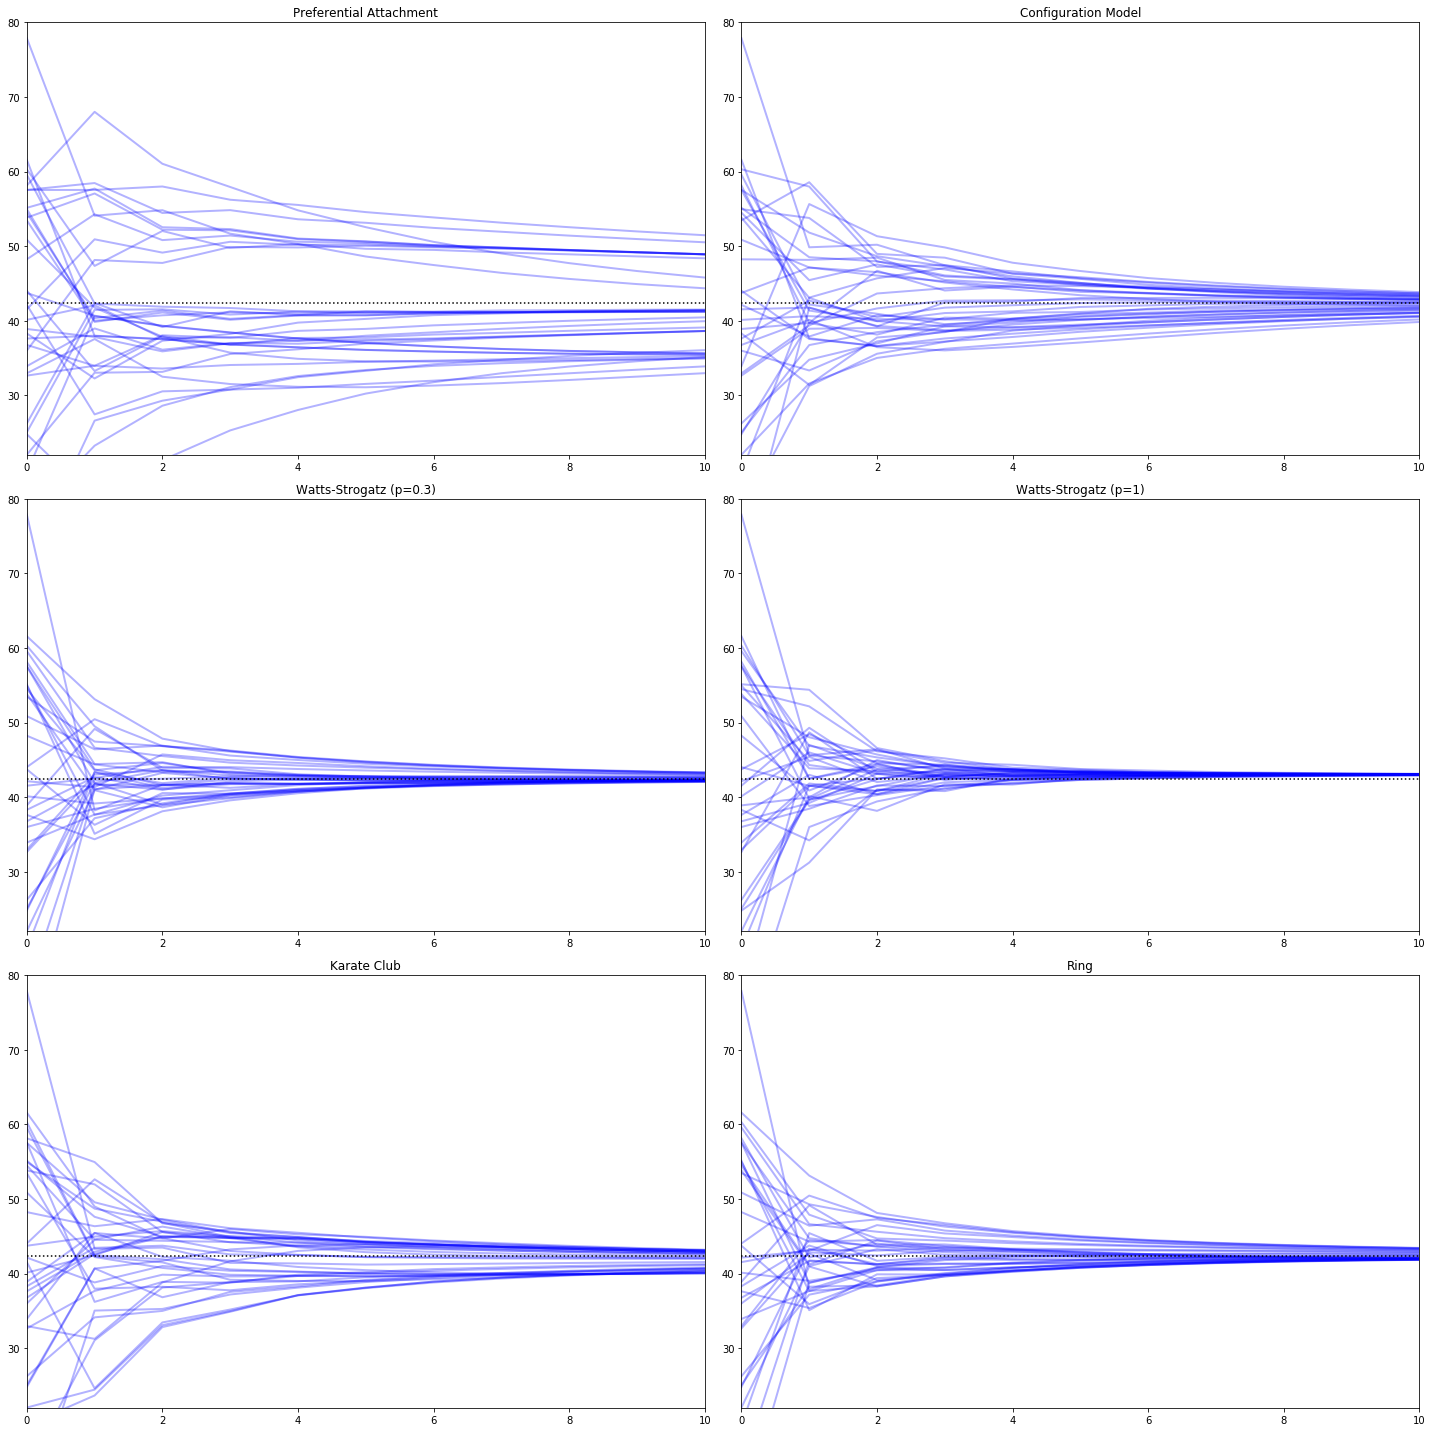

In [78]:
import random

def initial_beliefs(G, true_value=0, std=15):
  """Generate estimates of a true value with normally-distributed errors."""
  return dict( (v, random.gauss(true_value, std)) for v in G.nodes())

beliefs = initial_beliefs(G_karate, true_value=42)

def learning_step(G, beliefs):
    """Update each node's beliefs based on its neighbors' beliefs."""
    new_beliefs = dict()
    for v in G.nodes():
        # Include old belief in average
        total = beliefs[v]
        count = 1
        # Update average based on each neighbor
        for w in G.neighbors(v):
            total += beliefs[w]
            count += 1
        # Calculate average for node w
        new_beliefs[v] = total / count
    return new_beliefs

def plot_beliefs(G, initial_beliefs, true_value=0, steps=10):
    """Plot change in beliefs over time."""
    current_beliefs = dict(initial_beliefs)
    #beliefs = [current_beliefs]
    # Create dicts of x and y values for each node
    x = dict((v, list()) for v in G.nodes())
    y = dict((v, list()) for v in G.nodes())
    # Repeatedly update beliefs
    for i in range(steps + 1):
        for v in G.nodes():
            x[v].append(i)
            y[v].append(current_beliefs[v])
        if i < steps:
            current_beliefs = learning_step(G, current_beliefs)
            #beliefs.append(current_beliefs)
    # Plot evolution of each node's beliefs
    for v in G.nodes():
        plt.plot(x[v], y[v], 'b-', alpha=0.3, linewidth=2)
    # Plot mean value
    mean_value = sum(initial_beliefs.values()) / len(initial_beliefs)
    plt.plot([0, steps], [mean_value, mean_value], 'k:')
    # Add spines to plot
    ax = plt.gca()
    for spine in ax.spines.values(): spine.set_visible(True)
    plt.xlim([0, steps])
    plt.ylim([22, 80])

networks = {
    'Karate Club': G_karate,
    'Configuration Model': G2,
    'Preferential Attachment': nx.barabasi_albert_graph(34, 1),
    'Ring': nx.watts_strogatz_graph(34, 6, 0),
    'Watts-Strogatz (p=0.3)': nx.watts_strogatz_graph(34, 6, 0.1),
    'Watts-Strogatz (p=1)': nx.watts_strogatz_graph(34, 6, 1)
}

plt.figure(figsize=(20,20))
for i, (title, G) in enumerate(networks.items()):
    plt.subplot(3, 2, i + 1)
    plt.title(title)
    plot_beliefs(G, beliefs, 42)
plt.tight_layout()